In [1]:
%gui asyncio

In [2]:
import numpy as np
from minas.map_minas_support import *
np.random.seed(300)
classes = list(map(mkClass, range(1000)))
clusters = sampleClusters(classes)
inputStream = loopExamplesIter(classes)
examples = list(zip(range(200), inputStream))

In [3]:
from dask.distributed import Client
client = Client('tcp://192.168.15.14:8786', processes=False, asynchronous=False)

In [4]:
def minDist(clusters, item):
    dists = map(lambda cl: (sum((cl.center - item) ** 2) ** (1/2), cl), clusters)
    d, cl = min(dists, key=lambda x: x[0])
    return d, cl
counter = 0
results = []
init = time.time()
for i, example in examples:
    counter += 1
    result = minDist(clusters, example.item)
    results.append(result)
elapsed = time.time() - init
len(results)
print(f'minasOnline testSamples {elapsed} seconds, consumed {counter} items, {int(counter / elapsed)} i/s')

minasOnline testSamples 1.3143126964569092 seconds, consumed 200 items, 152 i/s


In [5]:
from streamz import Stream
import json

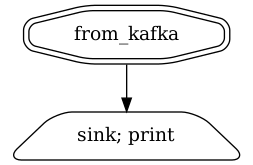

In [6]:
kafkaConfig = {'bootstrap.servers': 'localhost:9092', 'group.id': 'streamz-minas'}
kafkaSource = Stream.from_kafka(['minas'], kafkaConfig, start=True, asynchronous=True)

result = kafkaSource.sink(print)
result.visualize()

In [7]:
source = Stream()
source.sliding_window(3).sink(print)
for i in range(10):
    source.emit(i)

(0, 1, 2)
(1, 2, 3)
(2, 3, 4)
(3, 4, 5)
(4, 5, 6)
(5, 6, 7)
(6, 7, 8)
(7, 8, 9)


In [8]:
kafkaConfig = {'bootstrap.servers': 'localhost:9092', 'group.id': 'streamz-minas'}
topic = 'streamz-minas'
kafkaSource = Stream.from_kafka([topic], kafkaConfig, start=True)

# result = kafkaSource.sink(print)

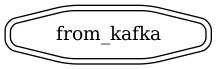

In [9]:
kafkaSource.visualize()

In [10]:
def exampleMap(di):
    if 'example' in di:
        return Example(**di['example'])
    return di
def minDistMap(example):
    return minDist(clusters, example.item)
def combinedMap(jsonItem):
    di = json.loads(jsonItem)
    example = exampleMap(di)
    timeDiff = time.time_ns() - example.timestamp
    return (minDistMap(example), timeDiff)
results = {}
def asSink(name):
    results[name] = []
    results[name + 'timestamp'] = time.time_ns()
    results[name + 'elapsed'] = time.time_ns()
    def f(val):
        results[name].append(val)
        results[name + 'elapsed'] = time.time_ns() - results[name + 'timestamp']
        print(name, val)
    return f
kafkaSource.map(combinedMap).sink(asSink('raw'))
kafkaSource.scatter(loop=client.loop).map(combinedMap).buffer(5).gather().sink(asSink('dask'))

ValueError: Two different event loops active

In [ ]:
kprod = confluent_kafka.Producer(kafkaConfig)
print(kprod.list_topics().topics)
init = time.time()
counter = 0
for i, example in examples:
    # value = repr(example)[:-1] + ', item=' + repr(example.item) + ')'
    example.timestamp = time.time_ns()
    value = json.dumps({'example': example.__getstate__()})
    kprod.produce(topic=topic, value=value, key=str(i))
    counter += 1
elapsed = time.time() - init
len(results)
print(f'kafka produce {elapsed} seconds, consumed {counter} items, {int(counter / elapsed)} i/s')

In [ ]:
result = source.pluck([0, 3]).sink(print)
result.visualize()

In [ ]:
result = source.buffer(10).accumulate(lambda acc, x: acc + 1, start=0).sink(print)
result.visualize()

In [ ]:
import confluent_kafka
kcons = confluent_kafka.Consumer({'bootstrap.servers': 'localhost:9092', 'group.id': 'pykafka'})
print(kcons.list_topics().topics)
kcons.subscribe(['test'])
messages = kcons.consume(num_messages=1000000, timeout=1)
for message in messages:
    reprr = [message.offset(), message.headers(), message.key(), message.value(), message.error()]
    print(reprr)

In [ ]:
kprod = confluent_kafka.Producer({'bootstrap.servers': 'localhost:9092'})
print(kprod.list_topics().topics)
for i in range(20):
    kprod.produce(topic='test', value=chr(97 + (i%26))* (i+1), key=str(i))

In [ ]:
import time
from streamz import Stream
from tornado.ioloop import IOLoop

def increment(x):
    """ A blocking increment function

    Simulates a computational function that was not designed to work
    asynchronously
    """
    time.sleep(0.1)
    return x + 1

def write(*args, **kwargs):
    print(*args, **kwargs)

async def f():
    source = Stream(asynchronous=True)
    source.scatter().map(increment).gather().sink(write)

    for x in range(10):
        await source.emit(x)
async def f2():
    source = Stream(asynchronous=True)
    source.map(increment).sink(write)

    for x in range(10):
        await source.emit(x)

In [ ]:
ini = time.time()
await f()
print(time.time() - ini)

In [ ]:
ini = time.time()
await f2()
print(time.time() - ini)

raw ((0.14119995143721822, Cluster(label=539, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.602289305757773, sumDistance=1.602289305757773, rolingVarianceSum=1.602289305757773, stdDev=1.602289305757773)), 89712661)
raw ((0.3779936860594565, Cluster(label=225, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.1967129735730102, sumDistance=1.1967129735730102, rolingVarianceSum=1.1967129735730102, stdDev=1.1967129735730102)), 109286321)
raw ((0.8959703781245483, Cluster(label=612, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.5680526815449656, sumDistance=1.5680526815449656, rolingVarianceSum=1.5680526815449656, stdDev=1.5680526815449656)), 121218115)
raw ((0.21733605208422, Cluster(label=566, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.874550114844861, sumDistance=1.874550114844861, rolingVariance

raw ((0.7416945125692224, Cluster(label=612, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.5680526815449656, sumDistance=1.5680526815449656, rolingVarianceSum=1.5680526815449656, stdDev=1.5680526815449656)), 731930357)
raw ((0.9407180752958951, Cluster(label=225, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.1967129735730102, sumDistance=1.1967129735730102, rolingVarianceSum=1.1967129735730102, stdDev=1.1967129735730102)), 742727343)
raw ((0.33292351610043186, Cluster(label=46, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.6786047399182544, sumDistance=0.6786047399182544, rolingVarianceSum=0.6786047399182544, stdDev=0.6786047399182544)), 752612762)
raw ((0.014430584104049645, Cluster(label=352, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.975883477780703, sumDistance=1.975883477780703, roling

raw ((0.563217646201984, Cluster(label=300, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.6063236930718598, sumDistance=0.6063236930718598, rolingVarianceSum=0.6063236930718598, stdDev=0.6063236930718598)), 1171915985)
raw ((0.015731599228089522, Cluster(label=977, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.0165822766940211, sumDistance=1.0165822766940211, rolingVarianceSum=1.0165822766940211, stdDev=1.0165822766940211)), 1183182331)
raw ((0.9341821817544913, Cluster(label=566, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.874550114844861, sumDistance=1.874550114844861, rolingVarianceSum=1.874550114844861, stdDev=1.874550114844861)), 1192365168)
raw ((0.11598226005809903, Cluster(label=581, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.7398991145474483, sumDistance=0.7398991145474483, rolin

raw ((0.14324120763626846, Cluster(label=692, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.7107778145125141, sumDistance=0.7107778145125141, rolingVarianceSum=0.7107778145125141, stdDev=0.7107778145125141)), 1631775349)
raw ((0.01374903033972613, Cluster(label=973, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.718543016309045, sumDistance=1.718543016309045, rolingVarianceSum=1.718543016309045, stdDev=1.718543016309045)), 1641418112)
raw ((0.6157723450907016, Cluster(label=299, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.9779256795417246, sumDistance=0.9779256795417246, rolingVarianceSum=0.9779256795417246, stdDev=0.9779256795417246)), 1652916304)
raw ((0.03393298545972234, Cluster(label=210, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.8994764108064097, sumDistance=1.8994764108064097, roli

raw ((1.4895428362799465, Cluster(label=545, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.6208719444588895, sumDistance=1.6208719444588895, rolingVarianceSum=1.6208719444588895, stdDev=1.6208719444588895)), 2073882240)
raw ((0.527196017548109, Cluster(label=567, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.7989124455322855, sumDistance=0.7989124455322855, rolingVarianceSum=0.7989124455322855, stdDev=0.7989124455322855)), 2083413914)
raw ((0.04348827510612856, Cluster(label=687, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.9252600176142718, sumDistance=0.9252600176142718, rolingVarianceSum=0.9252600176142718, stdDev=0.9252600176142718)), 2093521170)
raw ((1.0341424982451357, Cluster(label=566, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.874550114844861, sumDistance=1.874550114844861, rolin

raw ((0.036284471861079554, Cluster(label=247, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.9994292921076391, sumDistance=0.9994292921076391, rolingVarianceSum=0.9994292921076391, stdDev=0.9994292921076391)), 230771052)
raw ((0.45358710281004927, Cluster(label=938, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.49268942146534, sumDistance=0.49268942146534, rolingVarianceSum=0.49268942146534, stdDev=0.49268942146534)), 243957520)
raw ((0.1477266366277056, Cluster(label=539, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.602289305757773, sumDistance=1.602289305757773, rolingVarianceSum=1.602289305757773, stdDev=1.602289305757773)), 255711166)
raw ((0.014789705893986, Cluster(label=632, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.9785002780553415, sumDistance=0.9785002780553415, rolingVarianceSu

raw ((0.12390682417536203, Cluster(label=620, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.8264333258025767, sumDistance=1.8264333258025767, rolingVarianceSum=1.8264333258025767, stdDev=1.8264333258025767)), 684837466)
raw ((0.03310022959544505, Cluster(label=141, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.6834190579524175, sumDistance=0.6834190579524175, rolingVarianceSum=0.6834190579524175, stdDev=0.6834190579524175)), 707236191)
raw ((0.0852412212640822, Cluster(label=747, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.505909647860629, sumDistance=1.505909647860629, rolingVarianceSum=1.505909647860629, stdDev=1.505909647860629)), 725823842)
raw ((0.16472055507401165, Cluster(label=117, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.6608660327495537, sumDistance=1.6608660327495537, rolingV

raw ((0.015731599228089522, Cluster(label=977, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.0165822766940211, sumDistance=1.0165822766940211, rolingVarianceSum=1.0165822766940211, stdDev=1.0165822766940211)), 1125254112)
raw ((0.9341821817544913, Cluster(label=566, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.874550114844861, sumDistance=1.874550114844861, rolingVarianceSum=1.874550114844861, stdDev=1.874550114844861)), 1136264476)
raw ((0.11598226005809903, Cluster(label=581, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.7398991145474483, sumDistance=0.7398991145474483, rolingVarianceSum=0.7398991145474483, stdDev=0.7398991145474483)), 1147428910)
raw ((0.6881410233139271, Cluster(label=735, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.0817888289001187, sumDistance=1.0817888289001187, roli

raw ((0.005203284415297562, Cluster(label=194, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.9311310809828971, sumDistance=0.9311310809828971, rolingVarianceSum=0.9311310809828971, stdDev=0.9311310809828971)), 1553609261)
raw ((0.014260855428675433, Cluster(label=565, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.6204842653310181, sumDistance=0.6204842653310181, rolingVarianceSum=0.6204842653310181, stdDev=0.6204842653310181)), 1574816802)
raw ((0.029000076510262672, Cluster(label=126, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.44929434855486594, sumDistance=0.44929434855486594, rolingVarianceSum=0.44929434855486594, stdDev=0.44929434855486594)), 1592853746)
raw ((0.3825541839313763, Cluster(label=46, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.6786047399182544, sumDistance=0.678604739918

raw ((0.020548238041458586, Cluster(label=492, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.0356623434066838, sumDistance=1.0356623434066838, rolingVarianceSum=1.0356623434066838, stdDev=1.0356623434066838)), 1993875812)
raw ((0.3401692809675928, Cluster(label=300, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.6063236930718598, sumDistance=0.6063236930718598, rolingVarianceSum=0.6063236930718598, stdDev=0.6063236930718598)), 2012049961)
raw ((0.01661891498625377, Cluster(label=456, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.162628083317328, sumDistance=1.162628083317328, rolingVarianceSum=1.162628083317328, stdDev=1.162628083317328)), 2023136396)
raw ((0.008988724228326554, Cluster(label=151, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.7602278637423382, sumDistance=0.7602278637423382, ro

raw ((0.1456858458274974, Cluster(label=115, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.1429188731178899, sumDistance=1.1429188731178899, rolingVarianceSum=1.1429188731178899, stdDev=1.1429188731178899)), 2689089928)
raw ((0.04021091527000294, Cluster(label=117, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.6608660327495537, sumDistance=1.6608660327495537, rolingVarianceSum=1.6608660327495537, stdDev=1.6608660327495537)), 2704894058)
raw ((0.11904578247748028, Cluster(label=620, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.8264333258025767, sumDistance=1.8264333258025767, rolingVarianceSum=1.8264333258025767, stdDev=1.8264333258025767)), 2725159596)
raw ((0.4131571418649962, Cluster(label=68, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.0771212356667195, sumDistance=1.0771212356667195, ro

raw ((0.010333850168231129, Cluster(label=889, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.123542409096295, sumDistance=1.123542409096295, rolingVarianceSum=1.123542409096295, stdDev=1.123542409096295)), 562348575)
raw ((0.07117384145836639, Cluster(label=566, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.874550114844861, sumDistance=1.874550114844861, rolingVarianceSum=1.874550114844861, stdDev=1.874550114844861)), 578083339)
raw ((1.2324864729102207, Cluster(label=692, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.7107778145125141, sumDistance=0.7107778145125141, rolingVarianceSum=0.7107778145125141, stdDev=0.7107778145125141)), 590120126)
raw ((0.7416945125692224, Cluster(label=612, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.5680526815449656, sumDistance=1.5680526815449656, rolingVaria

raw ((0.4053490375069022, Cluster(label=300, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.6063236930718598, sumDistance=0.6063236930718598, rolingVarianceSum=0.6063236930718598, stdDev=0.6063236930718598)), 1003702601)
raw ((0.07312679353639688, Cluster(label=384, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.9159263841322752, sumDistance=0.9159263841322752, rolingVarianceSum=0.9159263841322752, stdDev=0.9159263841322752)), 1013742036)
raw ((0.06566711113310736, Cluster(label=814, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.7391977697861172, sumDistance=0.7391977697861172, rolingVarianceSum=0.7391977697861172, stdDev=0.7391977697861172)), 1025053073)
raw ((0.6672855477853531, Cluster(label=476, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.8583483097508398, sumDistance=0.8583483097508398, r

raw ((0.8101206444474397, Cluster(label=575, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.3123149225512052, sumDistance=1.3123149225512052, rolingVarianceSum=1.3123149225512052, stdDev=1.3123149225512052)), 1435317739)
raw ((2.364987809979299, Cluster(label=451, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.1235133693271528, sumDistance=1.1235133693271528, rolingVarianceSum=1.1235133693271528, stdDev=1.1235133693271528)), 1444898034)
raw ((0.017116450163224547, Cluster(label=396, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.0242177860589803, sumDistance=1.0242177860589803, rolingVarianceSum=1.0242177860589803, stdDev=1.0242177860589803)), 1455442025)
raw ((0.026817516390828463, Cluster(label=364, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.0496762845073158, sumDistance=1.0496762845073158, 

raw ((0.18932741720859617, Cluster(label=692, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.7107778145125141, sumDistance=0.7107778145125141, rolingVarianceSum=0.7107778145125141, stdDev=0.7107778145125141)), 1856914796)
raw ((1.388626168082135, Cluster(label=612, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.5680526815449656, sumDistance=1.5680526815449656, rolingVarianceSum=1.5680526815449656, stdDev=1.5680526815449656)), 1873118623)
raw ((0.531711460535858, Cluster(label=735, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.0817888289001187, sumDistance=1.0817888289001187, rolingVarianceSum=1.0817888289001187, stdDev=1.0817888289001187)), 1889993041)
raw ((0.6133029897494732, Cluster(label=451, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.1235133693271528, sumDistance=1.1235133693271528, roli

raw ((1.7187502386934144, Cluster(label=68, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.0771212356667195, sumDistance=1.0771212356667195, rolingVarianceSum=1.0771212356667195, stdDev=1.0771212356667195)), 2313268979)
raw ((0.00565521931833883, Cluster(label=92, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.8136372079522306, sumDistance=0.8136372079522306, rolingVarianceSum=0.8136372079522306, stdDev=0.8136372079522306)), 2325513642)
raw ((0.01500495058192483, Cluster(label=52, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.314328896670636, sumDistance=1.314328896670636, rolingVarianceSum=1.314328896670636, stdDev=1.314328896670636)), 2337920491)
raw ((0.018609375638955462, Cluster(label=414, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.6073047435337176, sumDistance=1.6073047435337176, roling

raw ((0.036284471861079554, Cluster(label=247, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.9994292921076391, sumDistance=0.9994292921076391, rolingVarianceSum=0.9994292921076391, stdDev=0.9994292921076391)), 269293703)
raw ((0.45358710281004927, Cluster(label=938, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.49268942146534, sumDistance=0.49268942146534, rolingVarianceSum=0.49268942146534, stdDev=0.49268942146534)), 284312001)
raw ((0.1477266366277056, Cluster(label=539, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.602289305757773, sumDistance=1.602289305757773, rolingVarianceSum=1.602289305757773, stdDev=1.602289305757773)), 299438316)
raw ((0.014789705893986, Cluster(label=632, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.9785002780553415, sumDistance=0.9785002780553415, rolingVarianceSu

raw ((0.7871336760725021, Cluster(label=384, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.9159263841322752, sumDistance=0.9159263841322752, rolingVarianceSum=0.9159263841322752, stdDev=0.9159263841322752)), 718557026)
raw ((0.7677744663348534, Cluster(label=375, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.5173647586476384, sumDistance=0.5173647586476384, rolingVarianceSum=0.5173647586476384, stdDev=0.5173647586476384)), 728855978)
raw ((0.11935215813357414, Cluster(label=141, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.6834190579524175, sumDistance=0.6834190579524175, rolingVarianceSum=0.6834190579524175, stdDev=0.6834190579524175)), 738978856)
raw ((1.5886268075159156, Cluster(label=141, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.6834190579524175, sumDistance=0.6834190579524175, rolin

raw ((0.11622079458263081, Cluster(label=620, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.8264333258025767, sumDistance=1.8264333258025767, rolingVarianceSum=1.8264333258025767, stdDev=1.8264333258025767)), 1137080471)
raw ((0.022151871120074645, Cluster(label=535, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.9410018154009281, sumDistance=0.9410018154009281, rolingVarianceSum=0.9410018154009281, stdDev=0.9410018154009281)), 1150342446)
raw ((0.019559058018056623, Cluster(label=715, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.256855194296875, sumDistance=1.256855194296875, rolingVarianceSum=1.256855194296875, stdDev=1.256855194296875)), 1160002985)
raw ((1.2022077069387578, Cluster(label=620, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.8264333258025767, sumDistance=1.8264333258025767, ro

raw ((0.7611442220941678, Cluster(label=689, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.1341674722209927, sumDistance=1.1341674722209927, rolingVarianceSum=1.1341674722209927, stdDev=1.1341674722209927)), 1598893069)
raw ((0.00816904133943299, Cluster(label=68, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.0771212356667195, sumDistance=1.0771212356667195, rolingVarianceSum=1.0771212356667195, stdDev=1.0771212356667195)), 1610632274)
raw ((0.024593837623609293, Cluster(label=578, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.9606887562368573, sumDistance=0.9606887562368573, rolingVarianceSum=0.9606887562368573, stdDev=0.9606887562368573)), 1621008170)
raw ((0.6967159641032259, Cluster(label=68, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.0771212356667195, sumDistance=1.0771212356667195, ro

raw ((0.18154534674106754, Cluster(label=605, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.9943088012819644, sumDistance=0.9943088012819644, rolingVarianceSum=0.9943088012819644, stdDev=0.9943088012819644)), 2016463950)
raw ((0.01891649881178843, Cluster(label=924, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=0.5951606946077697, sumDistance=0.5951606946077697, rolingVarianceSum=0.5951606946077697, stdDev=0.5951606946077697)), 2026059017)
raw ((1.4429763713565862, Cluster(label=612, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.5680526815449656, sumDistance=1.5680526815449656, rolingVarianceSum=1.5680526815449656, stdDev=1.5680526815449656)), 2037004179)
raw ((1.3747848182671272, Cluster(label=451, n=1, latest=0, timestamp=1558713125713136523, lastExapleTMS=0, maxDistance=0.0, meanDistance=1.1235133693271528, sumDistance=1.1235133693271528, r